# Exploratory Data Analysis and Diagnosis

Before modeling the data or doing any further analysis, an important step is to inspect the data at hand. More specifically, there are specific time series characteristics you might need to check, such as stationarity, effects of trend and seasonality, and autocorrelation, to name a few. These characteristics that describe the time series process you are working with need to be combined with domain knowledge behind the process itself.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

closing_price_url = 'https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook./main/datasets/Ch9/closing_price.csv'
air_passangers_url = 'https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook./main/datasets/Ch9/air_passenger.csv'

closing_price = pd.read_csv(closing_price_url,
                            index_col='Date',
                            parse_dates=True)
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

In [2]:
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

<AxesSubplot:xlabel='Date'>

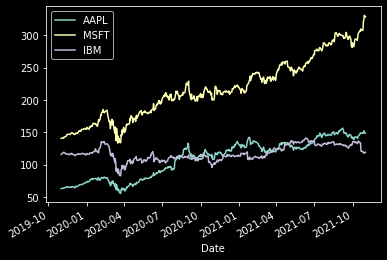

In [3]:
closing_price.plot()

<AxesSubplot:xlabel='Date'>

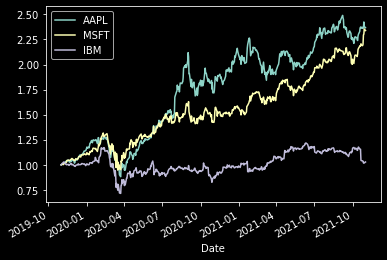

In [4]:
closing_price_n = closing_price.div(closing_price.iloc[0])
closing_price_n.plot()

In [5]:
closing_price_n.head()

AAPL      MSFT       IBM
Date                                    
2019-11-01  1.000000  1.000000  1.000000
2019-11-04  1.006567  1.005775  1.015790
2019-11-05  1.005121  1.005149  1.017413
2019-11-06  1.005551  1.002366  1.023980
2019-11-07  1.017156  1.003757  1.027937

<AxesSubplot:xlabel='Date'>

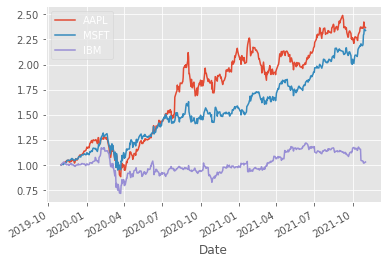

In [6]:
plt.style.use('ggplot')
closing_price_n.plot()

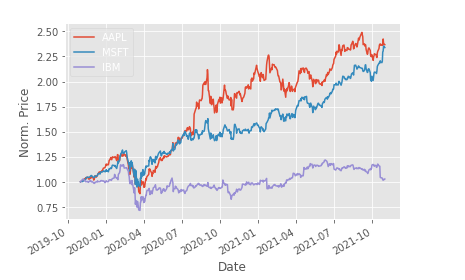

In [7]:
plot = closing_price_n.plot(title=f'Stock Prices from {closing_price_n.index.min()} - {closing_price_n.index.max()}'
                            , ylabel='Norm. Price')
plot.get_figure().savefig('./plots/plot_1.png')

## Plotting time series data with interactive visualizations using hvPlot

In [8]:
import hvplot as hv

closing_price_n.plot(backend='hvplot',title='Time Series plot using hvplot')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [9]:
closing_price.plot(backend='hvplot',width=300, subplots=True)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [10]:
closing_price.plot(backend='hvplot',width=300, subplots=True).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [11]:
(closing_price_n['AAPL'].plot(backend='hvplot',width=400) +
closing_price_n['MSFT'].plot(backend='hvplot',width=400))

:Layout
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

In [12]:
(closing_price_n['AAPL'].plot(backend='hvplot',width=400) *
closing_price_n['MSFT'].plot(backend='hvplot',width=400))

:Overlay
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

## Decomposing time series data

Before starting the modelling process, you will need to extract the components of the time series process for analysis. There are three major components for any time series process: trend, seasonality and residual. 

**Trend:** Gives a sense of the long-term direction of the time series and can be either upward, downward or horizontal.
**Seasonal:** Is a repeated patterns over time. 
**Residual:** Is simply the remaining or unexplained portion once we extract trend and seasonality.

The decomposition of a time series is the process of extracting the three components and representing them as their models. The modeling decomposition components can be either additive or multiplicative. 

1. Additive:
$$ y_{t} = T_{t} + S_{t} + R_{t}$$
2. Mutliplicative:
$$ y_{t} = T_{t} * S_{t} * R_{t}$$

A multiplicative model is suitable when the seasonal variation fluctuates over time.

Also you can group these into predictable versus non-predictable components. Predictable components are consistent, repeating patterns that can be captured and modeled. 

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
plt.rcParams["figure.figsize"] = (10,3)

<AxesSubplot:>

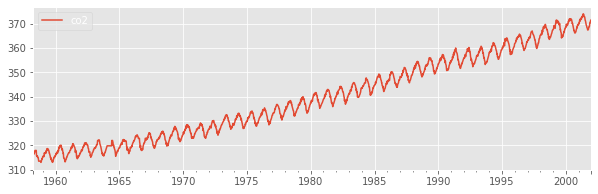

In [14]:
co2_df.plot()

<AxesSubplot:>

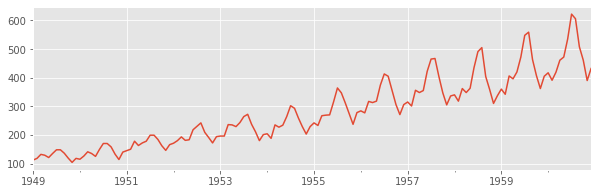

In [15]:
airp_df['value'].plot()

In [16]:
co2_decomposed = seasonal_decompose(co2_df,model='additive')
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')

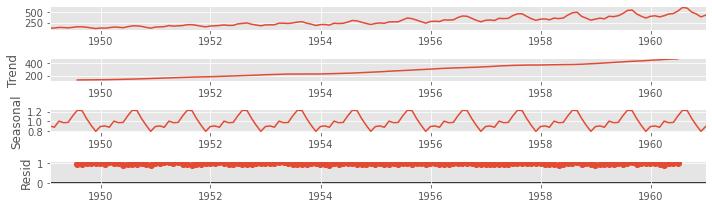

In [17]:
air_decomposed.plot(); plt.show()

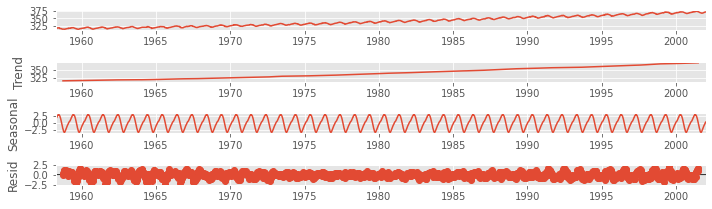

In [18]:
co2_decomposed.plot(); plt.show()

<AxesSubplot:>

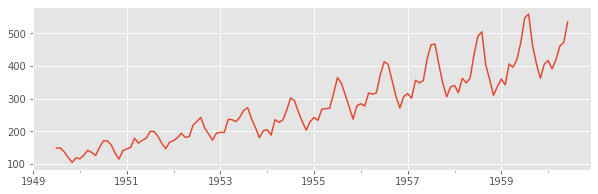

In [19]:
(air_decomposed.trend *
air_decomposed.seasonal *
air_decomposed.resid).plot()

<AxesSubplot:>

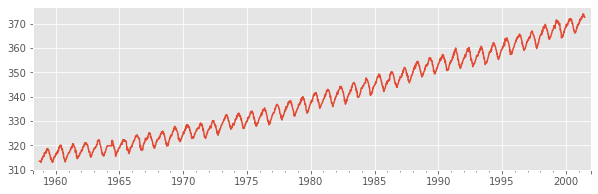

In [20]:
(co2_decomposed.trend +
co2_decomposed.seasonal +
co2_decomposed.resid).plot()

Another decomposition option is using the STL, which is a more advance tool for decomposition. In statsmodels, the STL class requires additional parameters than *seasonal_decompose* function. The two other parameters are seasonal and robust. The seasonal parameters refers for the seasonal smoother and can only take **odd integer values greater than or equal to 7.** Similarly, the STL function has a trend smoother. The second parameter is robuts, which takes a boolean value. Setting robuts to true, helps remove the impact of outliers on seasonal and trend components when calculated. 

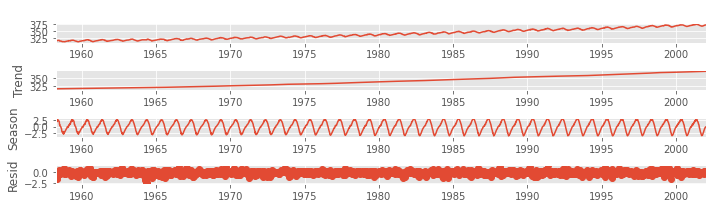

In [21]:
co2_stl = STL(
    co2_df,
    seasonal=13,
    robust=True).fit()
co2_stl.plot()
plt.show()

STL uses the LOESS seasonal smoother, which stands for Locally Estimated Scatterplot Smoothing. STL is more robust than seasonal_decompose for measuring non-linear relationships. On the other hand STL, asumes additive composition, so you do not need to indicate.

### Hodrick - Prescott filter

It is a smoothing filter that can be used to separate short-term fluctuations (cyclic variations) from long-term trends. Differently than STL or seasonal_decompose, hp_filter returns only two components: cyclical component and trend component. 

In [22]:
from statsmodels.tsa.filters.hp_filter import hpfilter
plt.rcParams['figure.figsize'] = (20,3)
co2_cyclic, co2_trend = hpfilter(co2_df)

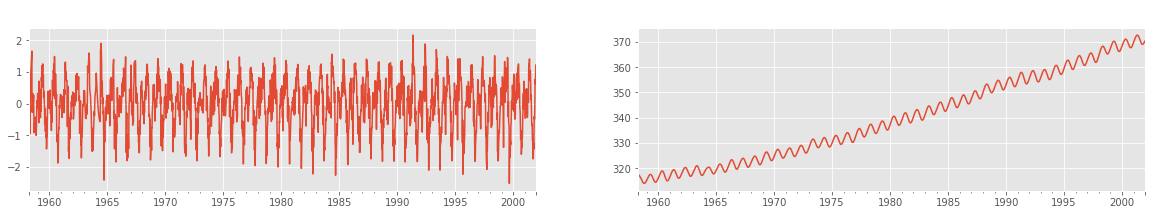

In [23]:
fig, ax = plt.subplots(1,2)
co2_cyclic.plot(ax=ax[0], title='CO2 Cyclic Component')
co2_trend.plot(ax=ax[1], title='CO2 Trend Component')
ax[0].title.set_size(20)
ax[1].title.set_size(20)

## Detecting time series stationarity

Several time series forecasting techniques assume stationarity. It is essential to understand whether the time series you are working is stationary or non-stationary. 

Stationary means that the statical properties do not vary over time, making the process easier to model and predict. On the other hand, a non-stationary process is more complex due to the dynamic nature and variations over time.

There are different approaches to define stationarity: some are strict and may not be possible to observe in real-world data, referred to as strong stationarity. In contrast, other definitions are more modest, and can be observed (or transformed into) real world data as weak stationarity.

There are two test to explore stationarity: Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. Both test for univariate time series process. Note that unit roots are just one cause for non-stationarity, but generally the presence of unit roots indicates non-stationarity. 

Both ADF and KPSS are based on linear regression. The null hypothesis for ADF states that there is a unit root in the time series, and thus, it is non-stationarity. On the other hand KPS has the opposite null hypothesis. 

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss

def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {'Test Statistic': test_score,
                    'p-value': pval,
                    'Numbers of lags': lags,
                    'decision': decision}
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

In [25]:
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

/mnt/c/Users/bcavagnaroo/OneDrive/Learning/DS_ML/TimeSeriesAnalisis_Python/python_timeseries/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [26]:
pd.concat([print_results(adf_output, 'adf'), print_results(kpss_output, 'kpss')], axis=1)

adf            kpss
Test Statistic               0.046051        7.649196
p-value                      0.962179            0.01
Numbers of lags                    27              29
decision               Non-Stationary  Non-Stationary
Critical Value (1%)         -3.433252           0.739
Critical Value (5%)         -2.862822           0.463
Critical Value (10%)        -2.567452           0.347
Critical Value (2.5%)             NaN           0.574

**Techniques for making time series stationary, such as transformations and differencing. The techniques are:**
- First-Order differencing
- Second-Order differencing
- Subtracting moving average
- Log transformation
- Decomposition
- Hodric-Prescott filter

Essentially, stationarity can be achieved by removing trend (detrend) and seasonality effects. For each transformation, we run stationarity tests and compare the results between the different tecniques. 

In [27]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    if adf_pv < 0.05:
    # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
    # Reject KPSS Null Hypothesis
        kpssh = 'Non-stationary'
    return (kpssh, adfh)

In [28]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2
        kpss_s, adf_s = check_stationarity(method)
        method.plot(kind=plot_type,ax=ax[v,r],legend=False, title=f'{name[0]} --> KPSS: {kpss_s}, ADF {adf_s}')
        ax[v,r].title.set_size(20)
        method.rolling(52).mean().plot(ax=ax[v,r],legend=False)

In [29]:
# First Order Differencing
first_order_diff = co2_df.diff().dropna()

In [30]:
# Second Order Differencing
differencing_twice = co2_df.diff(52).diff().dropna()

In [31]:
# Substracting moving average
rolling = co2_df.rolling(window=52).mean()
subtract_rolling_mean = co2_df - rolling

In [32]:
# Log transformation
import numpy as np

log_transform = np.log(co2_df)

In [33]:
# Using time series decomposition to remove the trend component, such as seasonal_decompose.
decomp = seasonal_decompose(co2_df)
sd_detrend = decomp.observed - decomp.trend

In [34]:
# Using Hodrick-Prescott filter:
cyclic, trend = hpfilter(co2_df)

/mnt/c/Users/bcavagnaroo/OneDrive/Learning/DS_ML/TimeSeriesAnalisis_Python/python_timeseries/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/mnt/c/Users/bcavagnaroo/OneDrive/Learning/DS_ML/TimeSeriesAnalisis_Python/python_timeseries/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/mnt/c/Users/bcavagnaroo/OneDrive/Learning/DS_ML/TimeSeriesAnalisis_Python/python_timeseries/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned

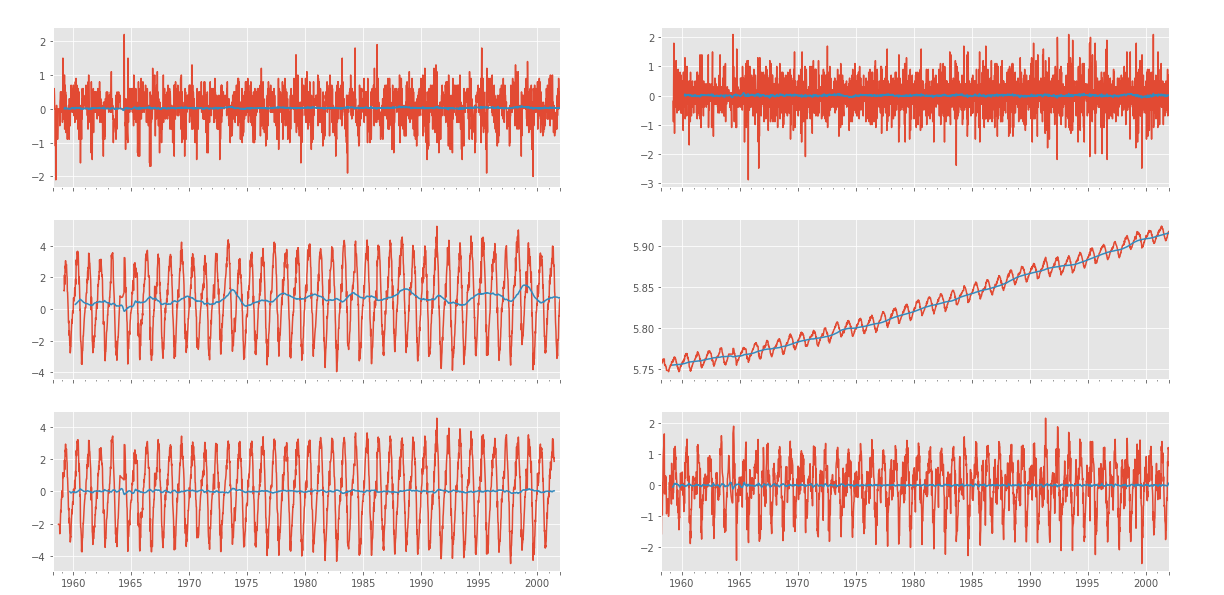

In [35]:
methods = [first_order_diff, differencing_twice,
subtract_rolling_mean, log_transform,
sd_detrend, cyclic]
plot_comparison(methods)

Generally, you do not want to over-difference your time series as some studies have shown that models based on over-differenced data are less accurate. For example, first_order_diff already made the time series stationary, and thus there was no need to difference it any further. In other words, differencing_twice was not needed. Additionally, notice how log_transform is still non-stationary.

## Applyin power Transformations

Depending on the model and analysis you are pursuing, you may need to test for additional assumptions against the observed dataset or the model's residuals. For example, testing for homoskedasticity (also spelled homoscedasticity) and normality. Homoskedasticity means that the variance is stable over time. More specifically, it is the variance of the residuals. When the variance is not constant, changing over time, we call
it heteroskedasticity (also spelled heteroscedasticity). Another assumption you will need to test for is normality; does the specific observation come from a normal (Gaussian) distribution? Sometimes, you may want to check the normality of the residuals as well, which can be part of the model diagnostics stage. Therefore, it is important to be aware of the assumptions made by specific models or techniques so you can determine which
test to use and against which dataset. If you do not do this, you may end up with a flawed model or an outcome that may be overly optimistic or overly pessimistic. 

Additionally, in this recipe, you will learn about Box-Cox transformation, which you can use to transform the data to satisfy normality and homoskedasticity.

The Box-Cox transformation relies on just one parameter, lambda ( λ ), and covers both logarithm and power transformations. If λ is 0, then you get a natural log transformation; otherwise, it's a power transformation. The approach is to try different values of 𝜆 and then test for normality and homoskedasticity.

In addition, you will be introduced to the White test and the Breusch-Pagan Lagrange statistical test for homoskedactisity. For normality diagnostics, you will explore the Shapiro-Wilk, D'Agostino-Pearson, and Kolmogorov-Smirnov statistical tests. Overall, Shapiro-Wilk tends to perform best and handles a broader set of cases.

In [36]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (20,8)

In [37]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal

In [38]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [42]:
normal_args = (np.mean(co2_df),np.std(co2_df))
print(is_normal(shapiro(co2_df)))
print(is_normal(normaltest(co2_df)))
#print(is_normal(normal_ad(co2_df)))
print(is_normal(kstest_normal(co2_df)))
print(is_normal(kstest(co2_df,cdf='norm',args=(np.mean(co2_df), np.std(co2_df)))))

/mnt/c/Users/bcavagnaroo/OneDrive/Learning/DS_ML/TimeSeriesAnalisis_Python/python_timeseries/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Not Normal
Not Normal
Not Normal
Not Normal


Sometimes, you may need to test normality as part of model evaluation and diagnostics. For example, you would evaluate the residuals (defined as the difference between actual and predicted values) if they follow a normal distribution. For now, you will run a simple autoregressive (AR(1)) model to demonstrate how you can use a normality test against the residuals of a model:

In [41]:
from statsmodels.tsa.api import AutoReg
model = AutoReg(co2_df.dropna(), lags=1).fit()

In [43]:
print(is_normal(shapiro(model.resid)))

Not Normal


In [44]:
from statsmodels.stats.api import (het_breuschpagan,
het_goldfeldquandt, het_white)

In [45]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (het_breuschpagan(model.resid,sm.add_constant(model.fittedvalues)))
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [46]:
het_test(model, test=het_breuschpagan)

'Homoskedastic'

In [47]:
het_test(model, test=het_white)

'Homoskedastic'

In [51]:
airp_df

value
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
...           ...
1960-08-31    606
1960-09-30    508
1960-10-31    461
1960-11-30    390
1960-12-31    432

[144 rows x 1 columns]

In [52]:
from scipy.stats import boxcox

xt, lmbda = boxcox(airp_df['value'])
xts = pd.Series(xt, index=airp_df.index)

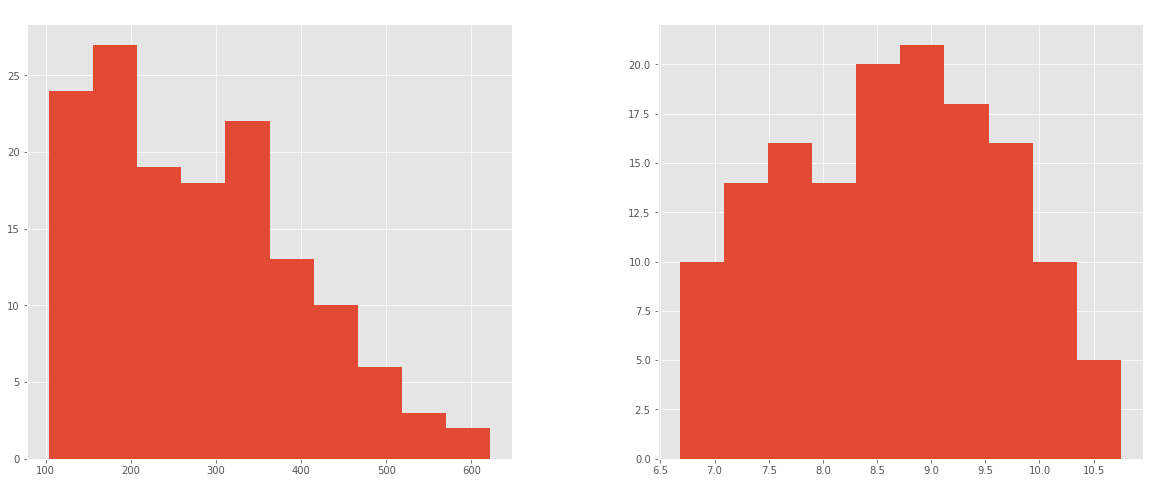

In [53]:
fig, ax = plt.subplots(1, 2)
airp_df.hist(ax=ax[0])
xts.hist(ax=ax[1])
plt.show()

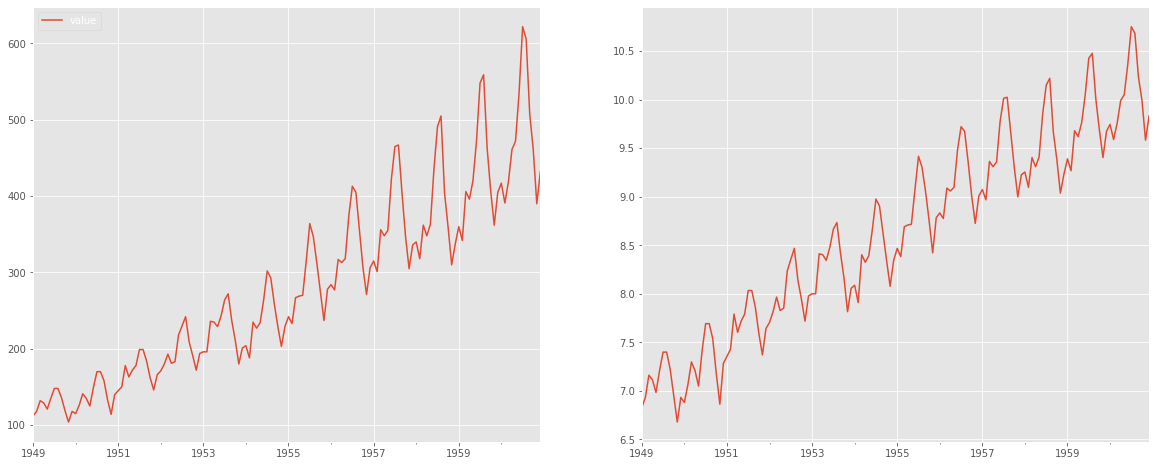

In [54]:
fig, ax = plt.subplots(1, 2)
airp_df.plot(ax=ax[0])
xts.plot(ax=ax[1])
plt.show()

<AxesSubplot:>

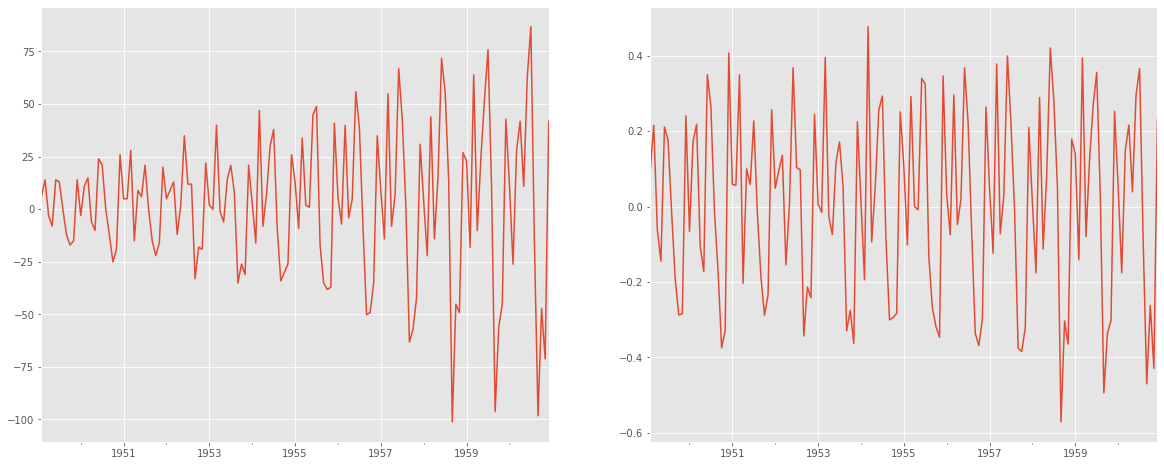

In [55]:
model_airp = AutoReg(airp_df, lags=1, trend='n').fit()
model_bx = AutoReg(xts, lags=1, trend='n').fit()
fig, ax = plt.subplots(1, 2)
model_airp.resid.plot(ax=ax[0])
model_bx.resid.plot(ax=ax[1])

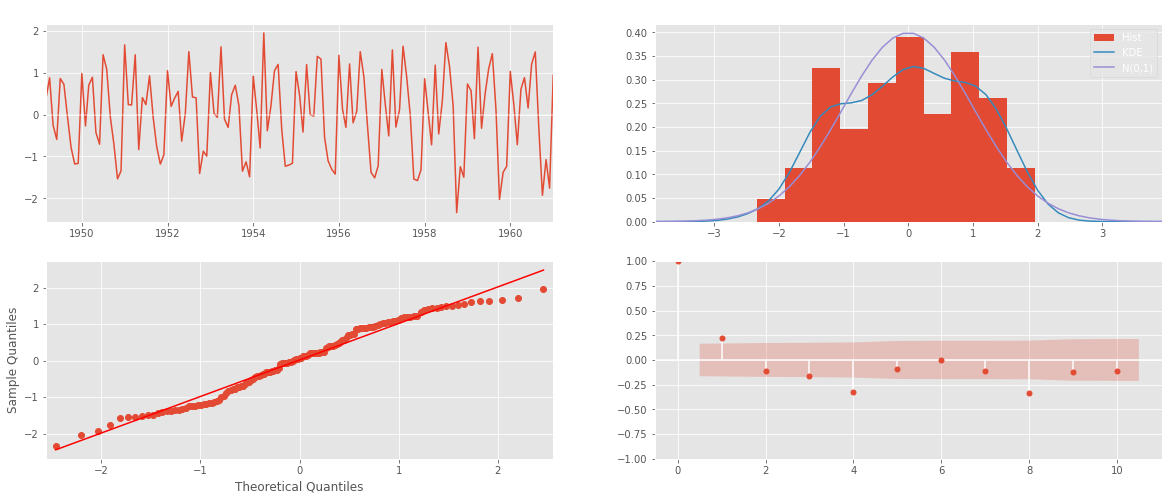

In [56]:
model_bx.plot_diagnostics(); plt.show()

## Testing for Autocorrelation

Autocorrelation is like statistical correlation (think Pearson correlation from high school), which measures the strength of a linear relationship between two variables, except that we measure the linear relationship between time series values separated by a lag. In other words, we are comparing a variable with its lagged version of itself.

Ljung-Box test to check for autocorrelations up to a specified lag and whether they are significantly far off from 0. The null hypothesis for the Ljung-Box test states that the previous lags are not correlated with the current period. In other words, you are testing for the absence of autocorrelation.

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [58]:
co2_diff= np.log(co2_df).diff().dropna()

In [59]:
acorr_ljungbox(co2_diff, lags=10, return_df=True)

lb_stat      lb_pvalue
1    16.193898   5.717801e-05
2    78.485798   9.057856e-18
3   287.050787   6.311581e-62
4   383.291716   1.132455e-81
5   493.588582  1.932434e-104
6   536.683057  1.047943e-112
7   598.257880  5.776363e-125
8   620.615981  8.637442e-129
9   626.775866  3.739862e-129
10  631.630413  2.925751e-129

In [60]:
acorr_ljungbox(model_bx.resid, return_df=True, lags=10)

lb_stat     lb_pvalue
1    6.891379  8.661245e-03
2    8.799865  1.227817e-02
3   12.728606  5.261829e-03
4   28.039695  1.224399e-05
5   29.201881  2.116595e-05
6   29.204901  5.563811e-05
7   31.021143  6.161812e-05
8   47.991784  9.915323e-08
9   50.468158  8.794752e-08
10  52.247452  1.026842e-07